# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Imports
import numpy as np
import tensorflow as tf
import pickle
import csv
import matplotlib.pyplot as plt

from tqdm import tqdm

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 8


get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')


In [49]:
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X, y = train['features'], train['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

A histogram of number of examples in each class

[ 210 2220 2250 1410 1980 1860  420 1440 1410 1470 2010 1320 2100 2160  780
  630  420 1110 1200  210  360  330  390  510  270 1500  600  240  540  270
  450  780  240  689  420 1200  390  210 2070  300  360  240  240]


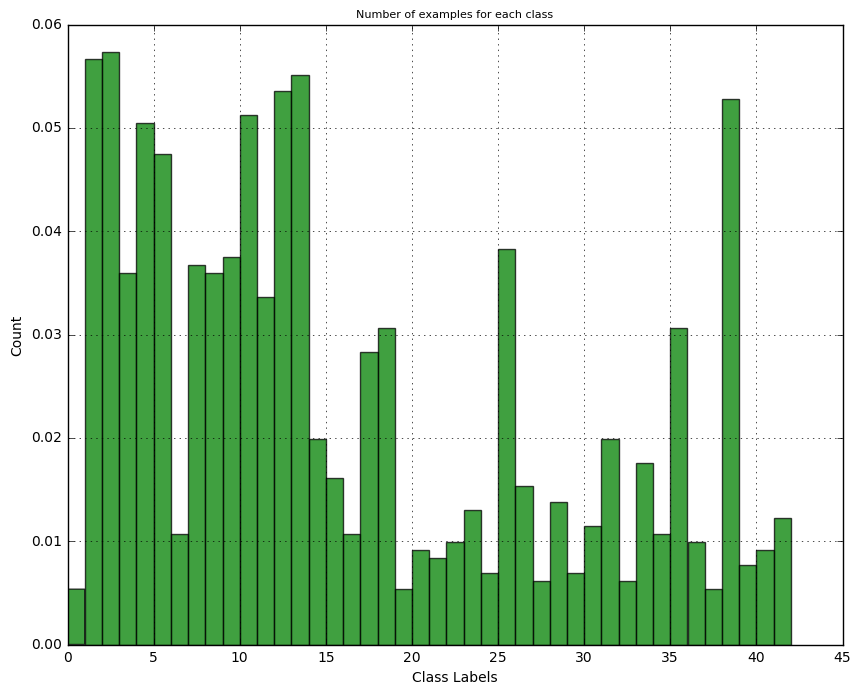

In [3]:
print (np.bincount(y))
n, bins, patches = plt.hist(y, bins = np.max(y), normed=1, facecolor='green', alpha=0.75)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Number of examples for each class")
plt.grid(True)
plt.show()

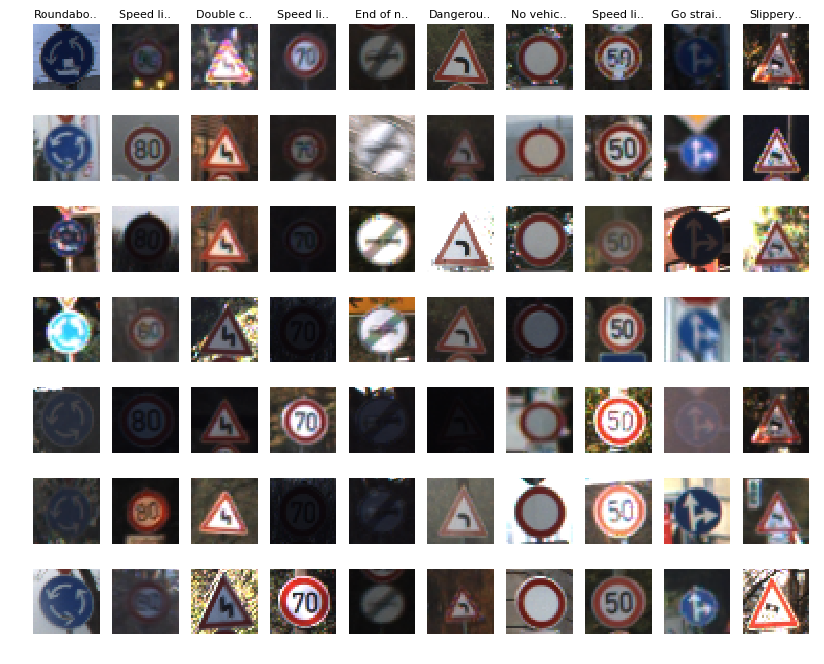

In [4]:
sign_names = {}

with open('signnames.csv', 'r') as csvfile:
    signreader = csv.reader(csvfile, delimiter=',')
    next(signreader, None)
    for row in signreader:
        sign_names[row[0]] = row[1]

str_len = 8
short_signnames = {int(key) : (name[:str_len] + (name[str_len:] and '..')) for key, name in sign_names.items()}       

# Randomly pick a subset of sign to visualize
samples_per_class = 7
cls_labels = np.random.choice(len(sign_names.keys()), 10, replace=False)
num_classes = len(cls_labels)
for ind, lbl in enumerate(cls_labels):
    idxs = np.flatnonzero(y == lbl)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + ind + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx])
        plt.axis('off')
        if i == 0:
           plt.title(short_signnames[lbl])
plt.show()

### Data Perturbation

In [53]:
import cv2

def timeIt(f, *args):
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    
    return toc-tic

def equalize_brightness(data):
    for i, img in enumerate(data):
        tmp = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        tmp[:, :, 0] = cv2.equalizeHist(tmp[:, :, 0])
        data[i] = cv2.cvtColor(tmp, cv2.COLOR_YUV2RGB)
        

timeIt(equalize_brightness, X) 

0.4962325096130371

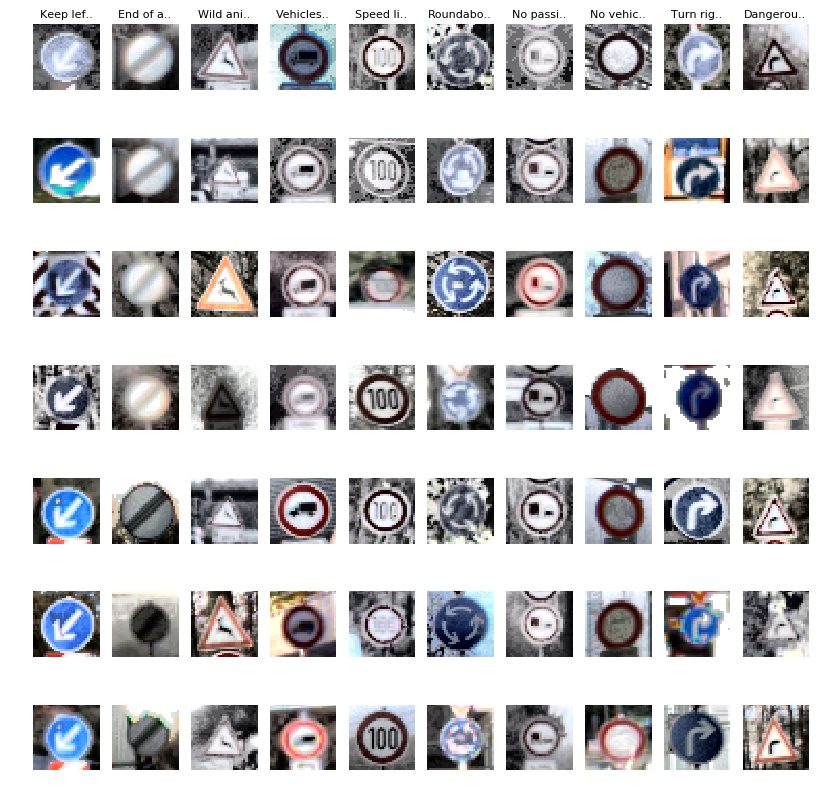

In [54]:
samples_per_class = 7
cls_labels = np.random.choice(len(sign_names.keys()), 10, replace=False)
num_classes = len(cls_labels)
for ind, lbl in enumerate(cls_labels):
    idxs = np.flatnonzero(y == lbl)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + ind + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx])
        plt.axis('off')
        if i == 0:
           plt.title(short_signnames[lbl])
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = X.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(sign_names.keys())

print("Number of training examples =", n_train)
#print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Image data shape = (32, 32, 3)
Number of classes = 43


In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

print ("Size of training examples", X.shape)
print ("Size of training ", X_train.shape)
print ("Size of training labels", y_train.shape)
print ("Size of validation ", X_valid.shape)
print ("Size of validation labels", y_valid.shape)

Size of training examples (39209, 32, 32, 3)
Size of training  (26270, 32, 32, 3)
Size of training labels (26270,)
Size of validation  (12939, 32, 32, 3)
Size of validation labels (12939,)


In [7]:
#Implementation of LeNet
from tensorflow.contrib.layers import flatten

mu = 0
sigma = 0.1

layer_depth = {
    'layer_1' : 6,
    'layer_2' : 16,
    'fully_connected_1' : 120,
    'fully_connected_2' : 84,
    'fully_connected_3' : n_classes,
}

weights = {
    'layer_1' : tf.Variable(tf.truncated_normal([5, 5, 3, layer_depth['layer_1']], mean=mu, stddev=sigma)),
    'layer_2' : tf.Variable(tf.truncated_normal([5, 5, layer_depth['layer_1'], layer_depth['layer_2']], mean=mu, stddev=sigma)),
    'fully_connected_1' : tf.Variable(tf.truncated_normal([400, layer_depth['fully_connected_1']], mean=mu, stddev=sigma)),
    'fully_connected_2' : tf.Variable(tf.truncated_normal([layer_depth['fully_connected_1'], layer_depth['fully_connected_2']], mean=mu, stddev=sigma)),
    'fully_connected_3' : tf.Variable(tf.truncated_normal([layer_depth['fully_connected_2'], layer_depth['fully_connected_3']], mean=mu, stddev=sigma))
}

biases = {
    'layer_1' : tf.Variable(tf.zeros(layer_depth['layer_1'])),
    'layer_2' : tf.Variable(tf.zeros(layer_depth['layer_2'])),
    'fully_connected_1' : tf.Variable(tf.zeros(layer_depth['fully_connected_1'])),
    'fully_connected_2' : tf.Variable(tf.zeros(layer_depth['fully_connected_2'])),
    'fully_connected_3' : tf.Variable(tf.zeros(layer_depth['fully_connected_3']))
}

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def LeNet(x):

    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # TODO: Activation.
    conv = conv2d(x, weights['layer_1'], biases['layer_1'])

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv = tf.nn.avg_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    # TODO: Activation.
    conv = conv2d(conv, weights['layer_2'], biases['layer_2'])

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv = tf.nn.avg_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    conv = flatten(conv)

    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    # TODO: Activation.

    #fc1 = tf.reshape(conv, [-1, weights['fully_connected_1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(conv, weights['fully_connected_1']),biases['fully_connected_1'])
    fc1 = tf.nn.tanh(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    # TODO: Activation.
    fc2 = tf.add(tf.matmul(fc1, weights['fully_connected_2']), biases['fully_connected_2'])
    fc2 = tf.nn.tanh(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3 = tf.add(tf.matmul(fc2, weights['fully_connected_3']), biases['fully_connected_3'])
    logits = tf.nn.tanh(fc3)

    return logits


In [8]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [9]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += loss
    return total_loss, total_accuracy / num_examples


In [ ]:
EPOCHS = 100
BATCH_SIZE = 128

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

loss_epoch = []
train_acc_epoch = []
valid_acc_epoch = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        _, training_accuracy = evaluate(X_train, y_train)
        loss, validation_accuracy = evaluate(X_valid, y_valid)
        
        loss_epoch.append(loss)
        train_acc_epoch.append(training_accuracy)
        valid_acc_epoch.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation loss = {:.3f}".format(loss))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, 'lenet')
    print("Model saved")



Training...

EPOCH 1 ...
Validation loss = 267.281
Validation Accuracy = 0.455

EPOCH 2 ...
Validation loss = 239.215
Validation Accuracy = 0.612

EPOCH 3 ...
Validation loss = 227.159
Validation Accuracy = 0.691

EPOCH 4 ...
Validation loss = 220.236
Validation Accuracy = 0.765

EPOCH 5 ...
Validation loss = 216.234
Validation Accuracy = 0.815

EPOCH 6 ...
Validation loss = 212.597
Validation Accuracy = 0.829

EPOCH 7 ...
Validation loss = 211.081
Validation Accuracy = 0.855

EPOCH 8 ...
Validation loss = 208.678
Validation Accuracy = 0.878

EPOCH 9 ...
Validation loss = 208.615
Validation Accuracy = 0.875

EPOCH 10 ...
Validation loss = 206.058
Validation Accuracy = 0.879

EPOCH 11 ...
Validation loss = 205.342
Validation Accuracy = 0.897

EPOCH 12 ...
Validation loss = 204.997
Validation Accuracy = 0.903

EPOCH 13 ...
Validation loss = 204.505
Validation Accuracy = 0.912

EPOCH 14 ...
Validation loss = 204.126
Validation Accuracy = 0.923

EPOCH 15 ...
Validation loss = 202.978
Valid

**Plot** the loss, trainig accuracy, and validation accuracy over epoch.

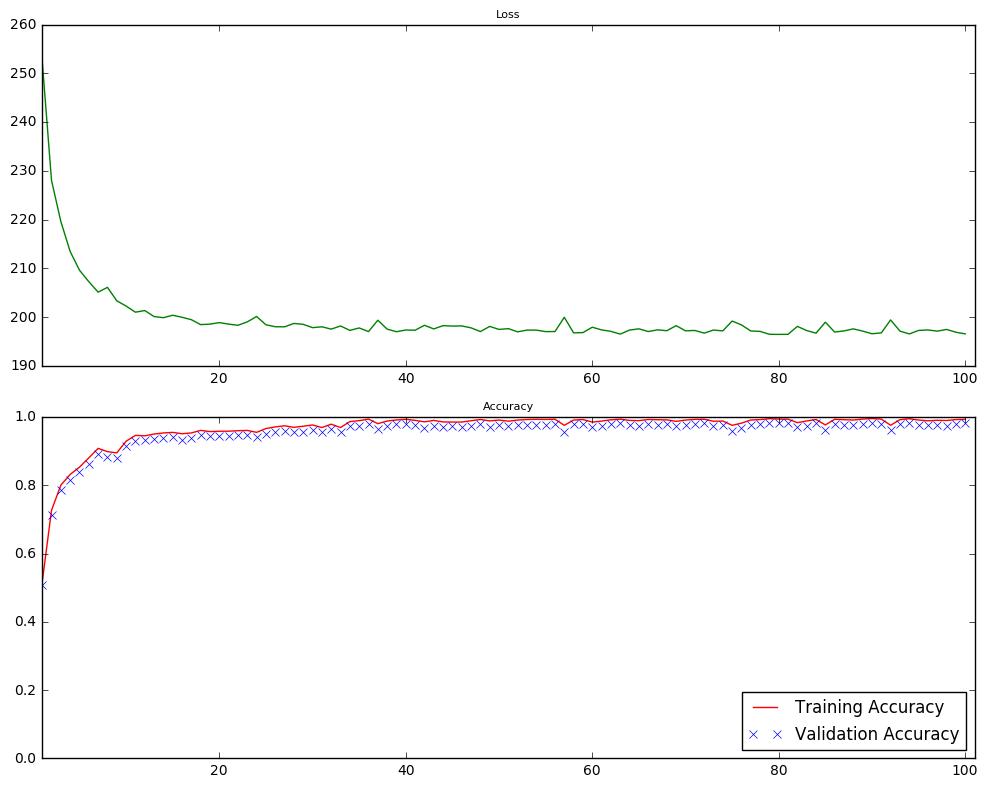

In [91]:
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(range(1, EPOCHS+1), loss_epoch, 'g')
loss_plot.set_xlim([1, EPOCHS+1])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(range(1, EPOCHS+1), train_acc_epoch, 'r', label='Training Accuracy')
acc_plot.plot(range(1, EPOCHS+1), valid_acc_epoch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([1, EPOCHS+1])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.